<a href="https://colab.research.google.com/github/AmeerAliSaleem/MA4J5_Project/blob/main/Ameer_Ali_Saleem_MA4J5_Main_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA4J5 Project: Predicting Amazon Review Scores with neural networks
---
### Ameer Ali Saleem

A Python notebook containing the Python code to support my MA4J5 report. Please note that this notebook has been written in Google Colab: this allows for the use of the TensorFlow package without requiring a direct installation (which would take roughly 1.1GB of storage). If you do not have TensorFlow installed, please click on the "Open in Colab" link at the top of the notebook.

# Imports and checks

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set seed for neural networks
# This will ensure that we yield the same network initialisation every time we run the code
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
keras.utils.set_random_seed(2)

In [ ]:
# set plotting background style
sns.set()

Our goal is to build a neural network to predict the rating (out of 5 stars) of an input Amazon Kindle review. The data used in this project can be found at <a href="https://nijianmo.github.io/amazon/index.html">this link</a>. In this notebook, we use the undersampled dataset, which should help alleviate the issue of class imbalance.

In [3]:
df = pd.read_csv("kindle_balanced.csv")

In [5]:
df.head()

,overall,reviewTime,reviewText,summary
0,1.0,"05 6, 2016",This reading did not have any real imagination...,This reading did not have any real imagination...
1,4.0,"05 19, 2013","This is a good read,I just wish we would get m...",good read
2,1.0,"09 16, 2016",Really?,One Star
3,3.0,"12 5, 2014",I thought the book was kind of disjointed. It...,"The book had a good story, but just a confusin..."
4,1.0,"04 29, 2015",Really a waste of time. Horribly boring.,Save your time...not worth it.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181465 entries, 0 to 181464
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     181465 non-null  float64
 1   reviewTime  181465 non-null  object 
 2   reviewText  181432 non-null  object 
 3   summary     181401 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.5+ MB


# Text Preprocessing

In [7]:
type(df["reviewText"].values)

numpy.ndarray

In [8]:
print(type(df["reviewText"].iloc[0]))

<class 'str'>


In [9]:
df["reviewText"] = df["reviewText"].astype(str)

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
reviews_cleaned = []

for i in range(len(df["reviewText"])):
  reviews_raw = df["reviewText"].iloc[i]
  reviews_edit_1 = reviews_raw.lower()
  reviews_edit_2 = re.sub(r"[^a-zA-Z0-9\s\.]", "", reviews_edit_1) # Filter punctuation
  # reviews_edit_3 = re.sub(" \.|\. ", "", reviews_edit_2) # Get rid of fullstops that are outside of words
  reviews_cleaned.append(reviews_edit_2.strip()) # remove unnecessary whitespace and append to list of cleaned reviews


# vectorised code
# reviews_edit_1 = df["reviewText"].str.lower() # Convert all reviewText to lowercase
# reviews_edit_2 = reviews_edit_1.str.replace(r"[^a-zA-Z0-9\s\.]", "") # Filter that punctuation g
# reviews_cleaned = reviews_edit_2.str.strip().tolist() # Remove unnecessary whitespace

In [12]:
# remove stopwords from the cleaned list
filtered_reviews = [
    ' '.join(word for word in sentence.split() if word.lower() not in stopwords)
    for sentence in reviews_cleaned
]

In [13]:
# compare first record vs record with stopwords removed
print(reviews_cleaned[0])
print(filtered_reviews[0])

this reading did not have any real imagination in it.  i really could not see the point the story was trying to make.
reading real imagination it. really could see point story trying make.


In [14]:
# observe first five filtered reviews + scores
for i in range(5):
  print(filtered_reviews[i])
  print(df["overall"][i])

reading real imagination it. really could see point story trying make.
1.0
good readi wish would get information mystery bernie. soon would good.
4.0
really
1.0
thought book kind disjointed. seems chapter left hanging without explanation. never really explain relationship mother lord froste helping book good story confusing way get there.
3.0
really waste time. horribly boring.
1.0


## Train-test split

In [15]:
labels = list(df["overall"])

# Shuffle the data.

filtered_reviews, labels = zip(*random.sample(list(zip(filtered_reviews,labels)), len(filtered_reviews)))
filtered_reviews = list(filtered_reviews)
labels = list(labels)

# Train-test split (66:33)

trainsize = int(len(filtered_reviews)*0.66)

train_reviews, train_labels = filtered_reviews[:trainsize], labels[:trainsize]
test_reviews, test_labels = filtered_reviews[trainsize:], labels[trainsize:]

In [16]:
# Check distribution reviews (1,2,3,4,5) in the training set

print("TRAINING SET")
print("Number of reviews to use for training is: {}.".format(len(train_labels)))
print("Number of 5-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==5),100*sum(np.array(train_labels)==5)/len(train_labels)))
print("Number of 4-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==4),100*sum(np.array(train_labels)==4)/len(train_labels)))
print("Number of 3-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==3),100*sum(np.array(train_labels)==3)/len(train_labels)))
print("Number of 2-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of 1-star reviews is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))

TRAINING SET
Number of reviews to use for training is: 119766.
Number of 5-star reviews is: 23912 (or 20.0%).
Number of 4-star reviews is: 23966 (or 20.0%).
Number of 3-star reviews is: 23947 (or 20.0%).
Number of 2-star reviews is: 24001 (or 20.0%).
Number of 1-star reviews is: 23940 (or 20.0%).


## Tokenisation

The word tokenizer provided by the Keras package will be able to deal with full stops for us, e.g. "missing." and "missing" will be treated as the same token.

Now for the tokenisation. In particular, we must conduct this separately on the training and test sets. The reason for this is due to so-called "data leakage": we do not want to introduce any elements of the testing data to the network before or during training. These two sets should be kept as separate as possible.

In [52]:
# max size of our vectorised corpus
vocab_size = 20000

# maximum allowed length for each vectorised sentence into our neural network
max_length = 50

# Tokenization
# OOV token deals with words that our tokenizer has not seen before (e.g. in the test set)
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index

# print out our dictionary of vectors
# print(word_index)


train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# padding sequences to standardise the input size of each row of data for our NN
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [53]:
print(type(train_labels[0]))

train_labels_int = [int(x) for x in train_labels]
test_labels_int = [int(x) for x in test_labels]

print(type(train_labels_int[0]))

<class 'float'>
<class 'int'>


In [54]:
print(len(word_index))

94510


# Model Building and Evaluation

We now experiment with a variety of neural network architectures, with the aim of maximising the accuracy of our model on the *testing set*.

In [20]:
# function to plot and analyse the learning of each neural network
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [21]:
# more model parameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

###Experimenting with activation layers [pooling]
---

In [133]:
def pooling(embedding_dim, num_epochs, batch_size, activation_func):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation=activation_func),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.summary()

  history = model.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

  learning_curve(history)

  return history

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dense_62 (Dense)            (None, 16)                528       
                                                                 
 dense_63 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 4s - loss: 1.2124 - accuracy: 0.2371 - val_loss: 1.1293 - val_

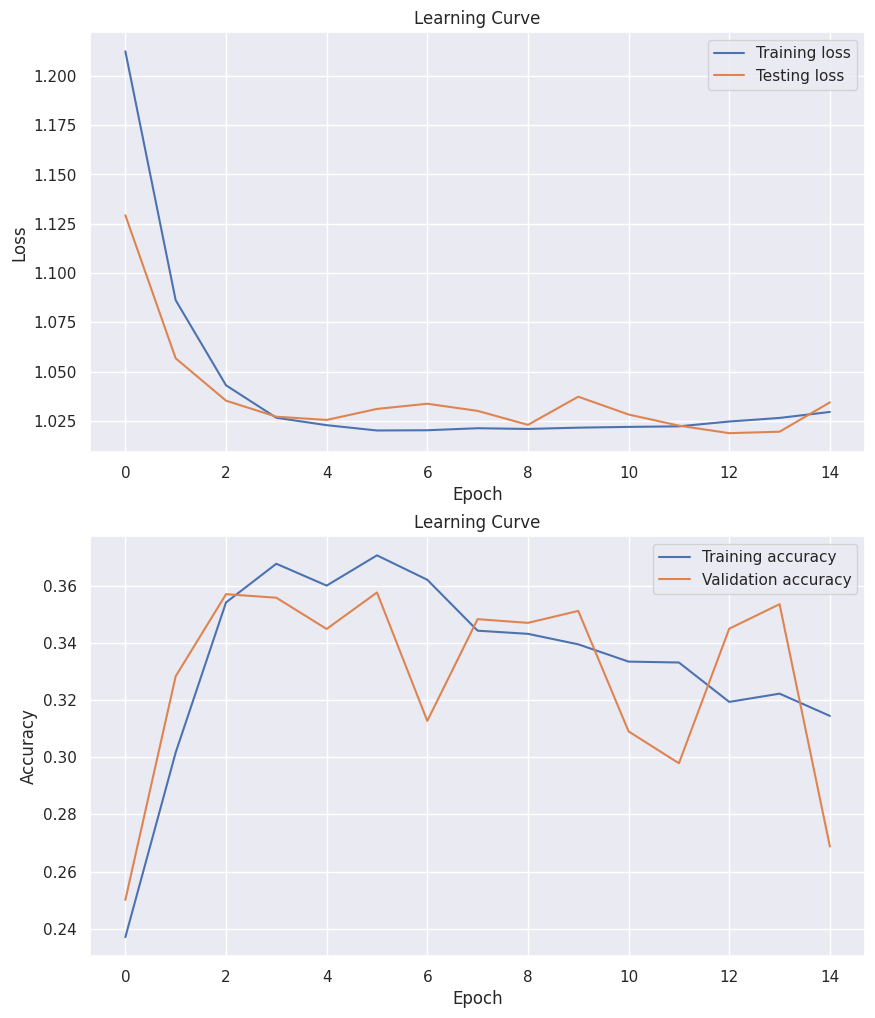

In [134]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_1 = pooling(embedding_dim, num_epochs, batch_size, 'relu')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 7 (GlobalAveragePooling1D)                                      
                                                                 
 dense_64 (Dense)            (None, 16)                528       
                                                                 
 dense_65 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 4s - loss: 1.2110 - accuracy: 0.1999 - val_loss: 1.1667 - val_

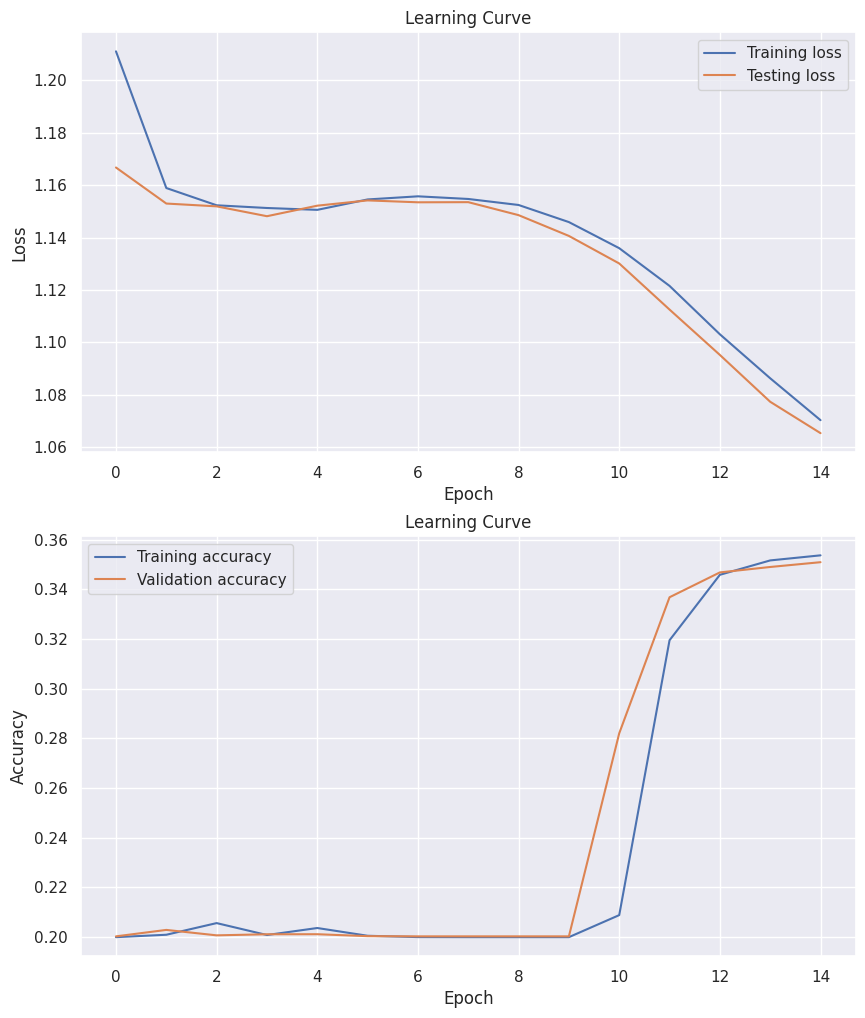

In [136]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_2 = pooling(embedding_dim, num_epochs, batch_size, 'sigmoid')

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 8 (GlobalAveragePooling1D)                                      
                                                                 
 dense_66 (Dense)            (None, 16)                528       
                                                                 
 dense_67 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 5s - loss: 1.2698 - accuracy: 0.2060 - val_loss: 1.2445 - val_

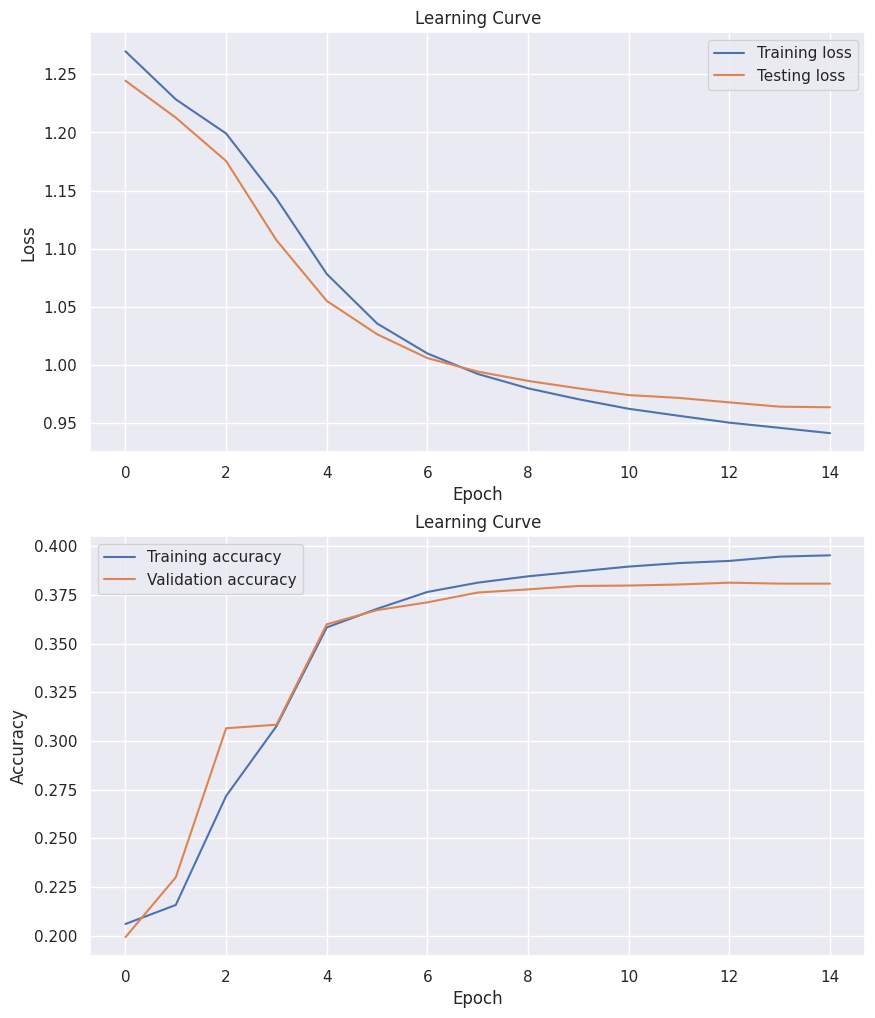

In [137]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_3 = pooling(embedding_dim, num_epochs, batch_size, 'softmax')

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 9 (GlobalAveragePooling1D)                                      
                                                                 
 dense_68 (Dense)            (None, 16)                528       
                                                                 
 dense_69 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 4s - loss: 1.1940 - accuracy: 0.2106 - val_loss: 1.1254 - val_

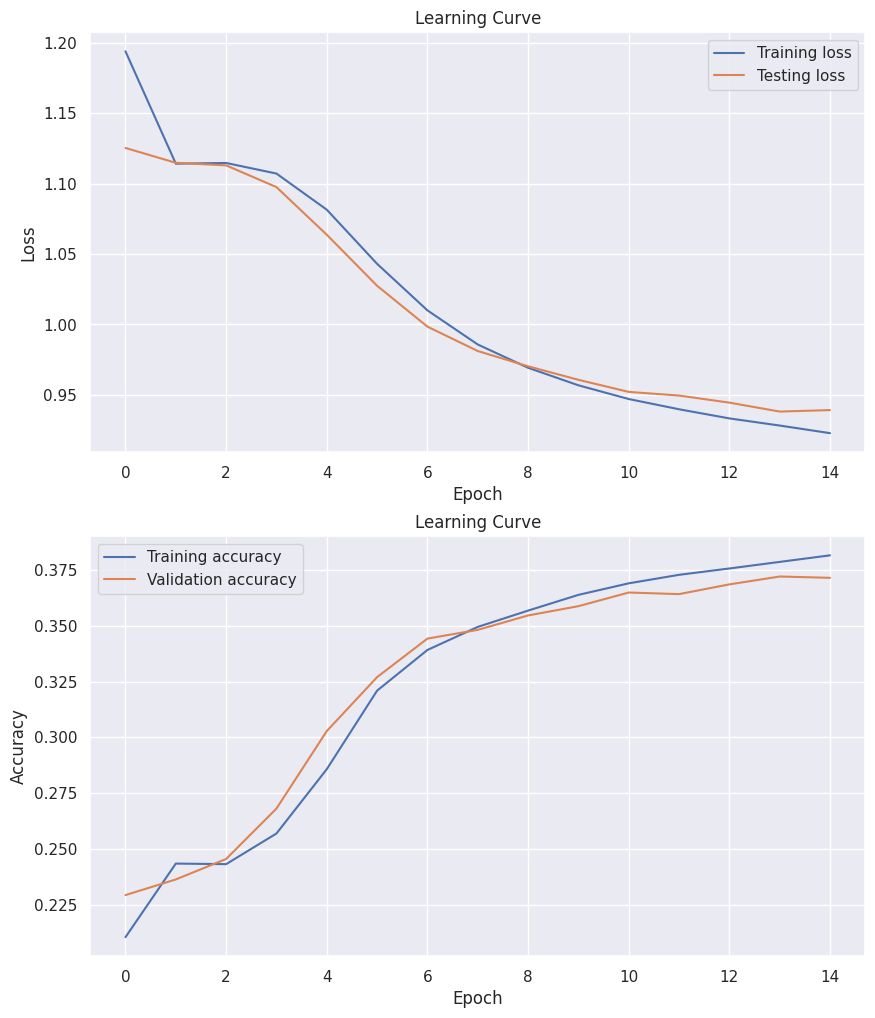

In [138]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_4 = pooling(embedding_dim, num_epochs, batch_size, 'tanh')

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 50, 32)            640000    
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_70 (Dense)            (None, 16)                528       
                                                                 
 dense_71 (Dense)            (None, 5)                 85        
                                                                 
Total params: 640613 (2.44 MB)
Trainable params: 640613 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 4s - loss: 1.2193 - accuracy: 0.2050 - val_loss: 1.1477 - val_

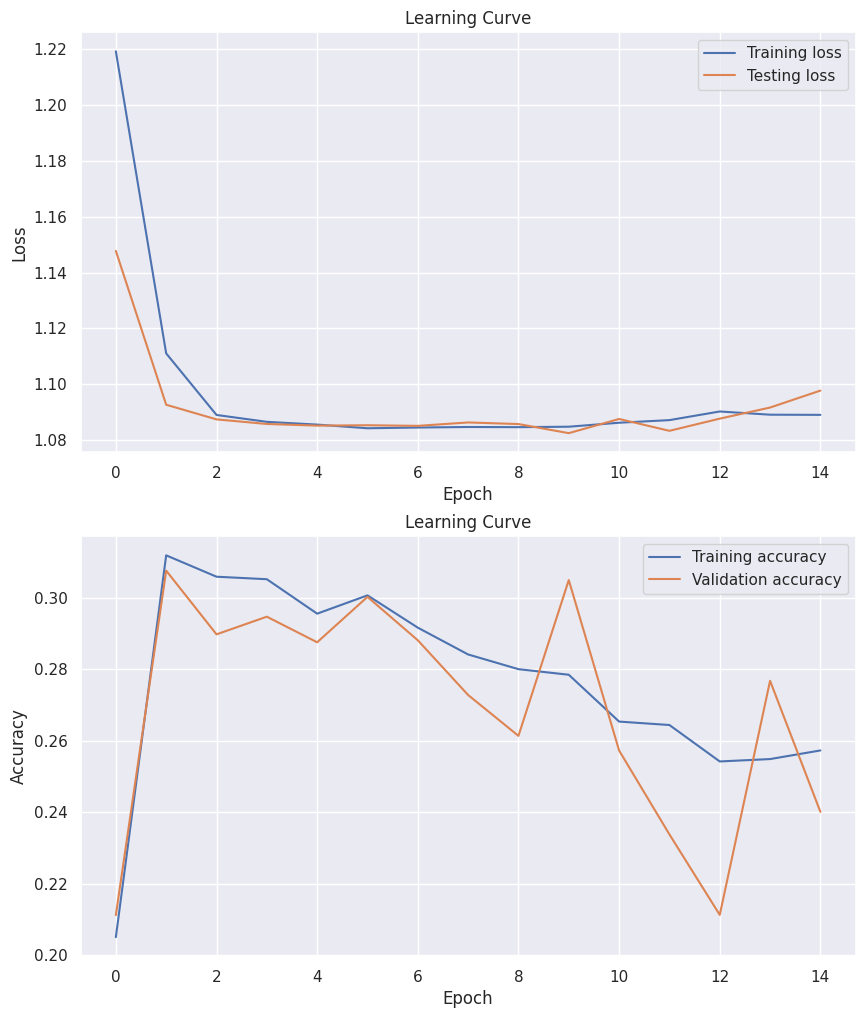

In [139]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_pooling_5 = pooling(embedding_dim, num_epochs, batch_size, 'leaky_relu')

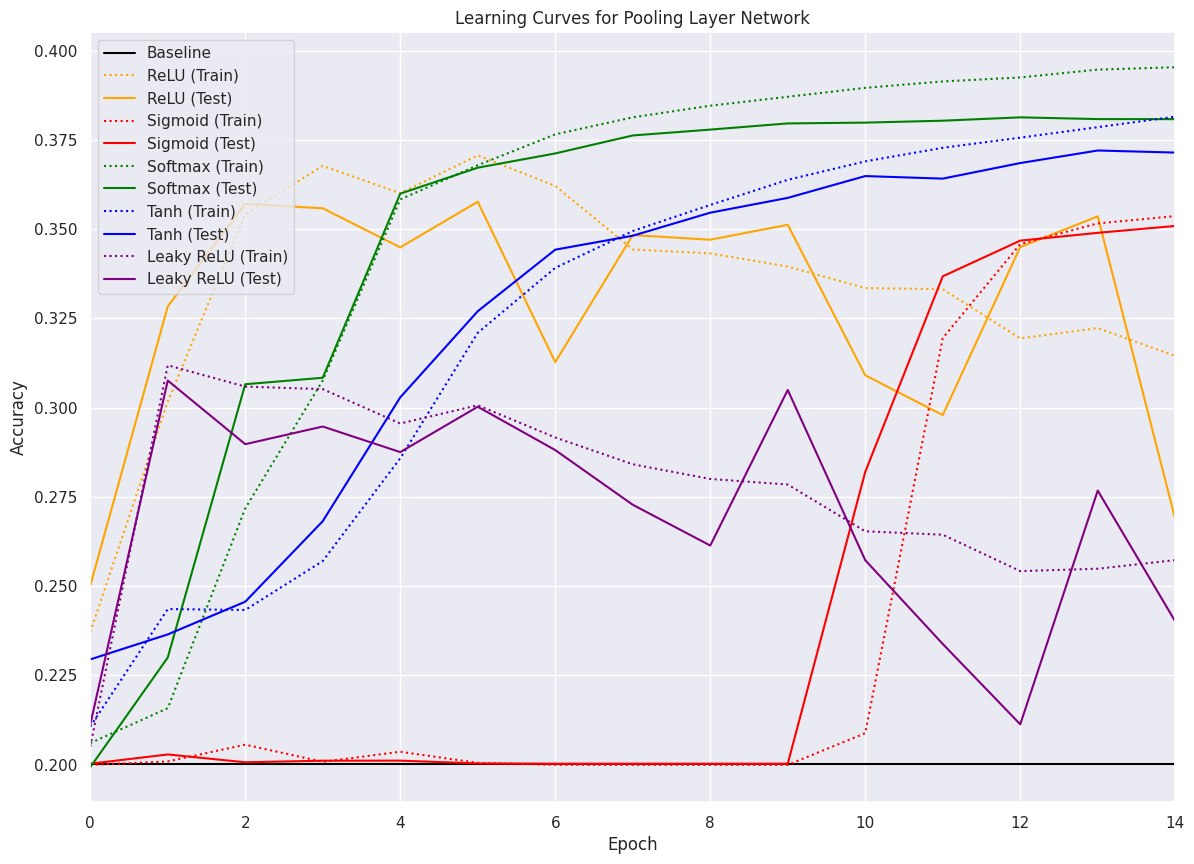

In [141]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))
sns.set()

plt.axhline(0.2, label='Baseline', color='black')
plt.plot(history_pooling_1.history['accuracy'], label='ReLU (Train)', color='orange', linestyle='dotted')
plt.plot(history_pooling_1.history['val_accuracy'], label='ReLU (Test)', color='orange')
plt.plot(history_pooling_2.history['accuracy'], label='Sigmoid (Train)', color='red', linestyle='dotted')
plt.plot(history_pooling_2.history['val_accuracy'], label='Sigmoid (Test)', color='red')
plt.plot(history_pooling_3.history['accuracy'], label='Softmax (Train)', color='green', linestyle='dotted')
plt.plot(history_pooling_3.history['val_accuracy'], label='Softmax (Test)', color='green')
plt.plot(history_pooling_4.history['accuracy'], label='Tanh (Train)', color='blue', linestyle='dotted')
plt.plot(history_pooling_4.history['val_accuracy'], label='Tanh (Test)', color='blue')
plt.plot(history_pooling_5.history['accuracy'], label='Leaky ReLU (Train)', color='purple', linestyle='dotted')
plt.plot(history_pooling_5.history['val_accuracy'], label='Leaky ReLU (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
# plt.ylim((0.2,0.8))
plt.title('Learning Curves for Pooling Layer Network')

plt.show()

### Experimenting with activation layers [flatten]
---

In [145]:
def flatten(embedding_dim, num_epochs, batch_size, activation_func):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation=activation_func),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.summary()

  history = model.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

  learning_curve(history)

  return history

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 50, 32)            640000    
                                                                 
 flatten_11 (Flatten)        (None, 1600)              0         
                                                                 
 dense_76 (Dense)            (None, 16)                25616     
                                                                 
 dense_77 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 4s - loss: 1.1436 - accuracy: 0.2165 - val_loss: 1.0686 - val_accuracy: 0.2543 - 4s/epoch - 37ms/step
Epoch 2/15
120/120 - 4s - 

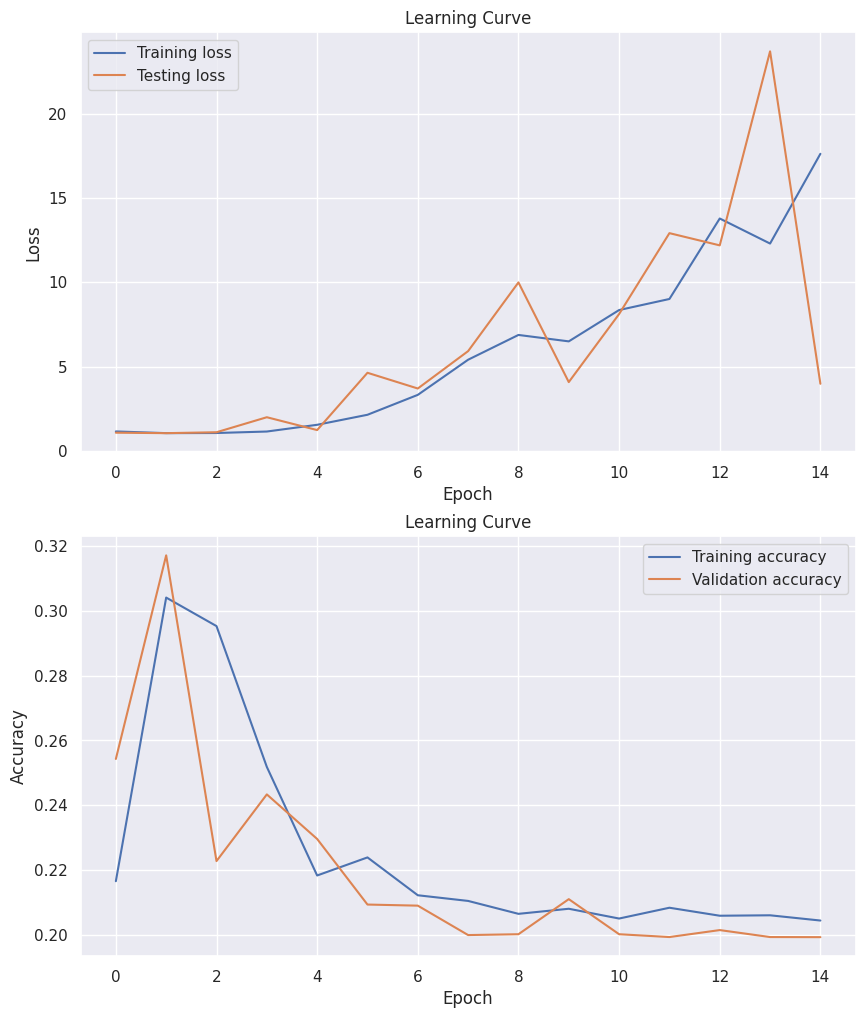

In [146]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_1 = flatten(embedding_dim, num_epochs, batch_size, 'relu')

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 50, 32)            640000    
                                                                 
 flatten_12 (Flatten)        (None, 1600)              0         
                                                                 
 dense_78 (Dense)            (None, 16)                25616     
                                                                 
 dense_79 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 5s - loss: 1.2405 - accuracy: 0.2229 - val_loss: 1.1976 - val_accuracy: 0.2972 - 5s/epoch - 41ms/step
Epoch 2/15
120/120 - 4s - 

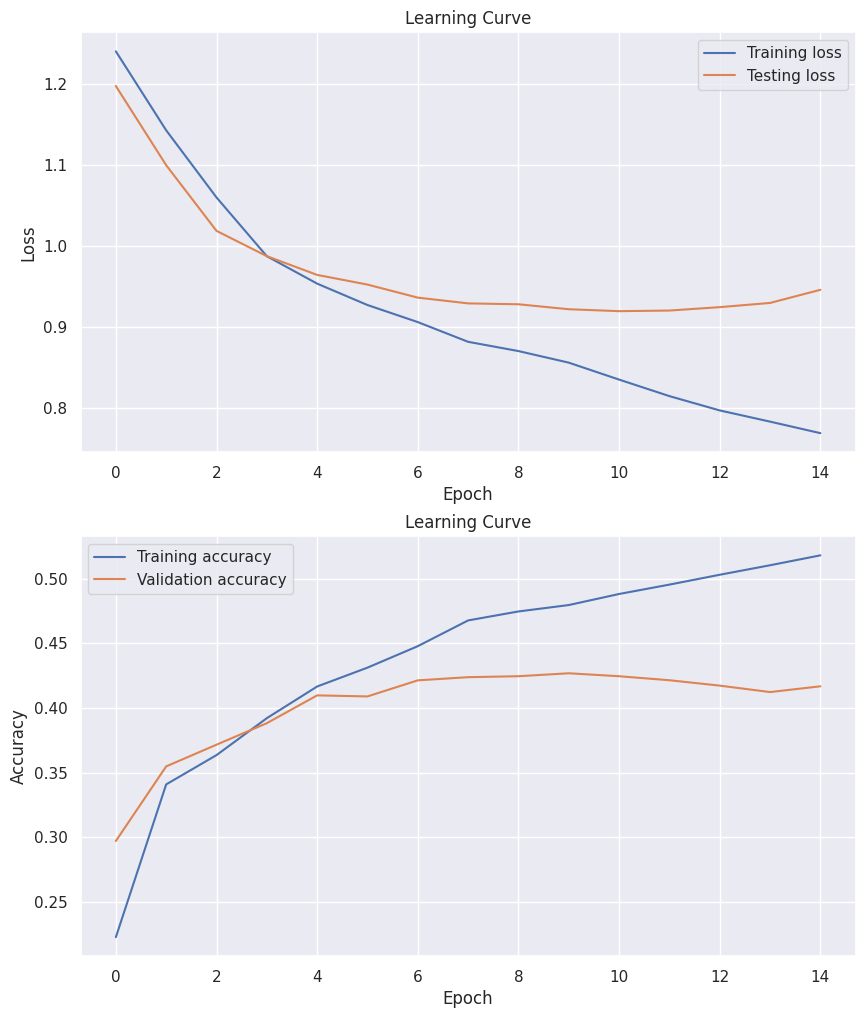

In [147]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_2 = flatten(embedding_dim, num_epochs, batch_size, 'sigmoid')

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 50, 32)            640000    
                                                                 
 flatten_13 (Flatten)        (None, 1600)              0         
                                                                 
 dense_80 (Dense)            (None, 16)                25616     
                                                                 
 dense_81 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 6s - loss: 1.2501 - accuracy: 0.2017 - val_loss: 1.2343 - val_accuracy: 0.2001 - 6s/epoch - 52ms/step
Epoch 2/15
120/120 - 4s - 

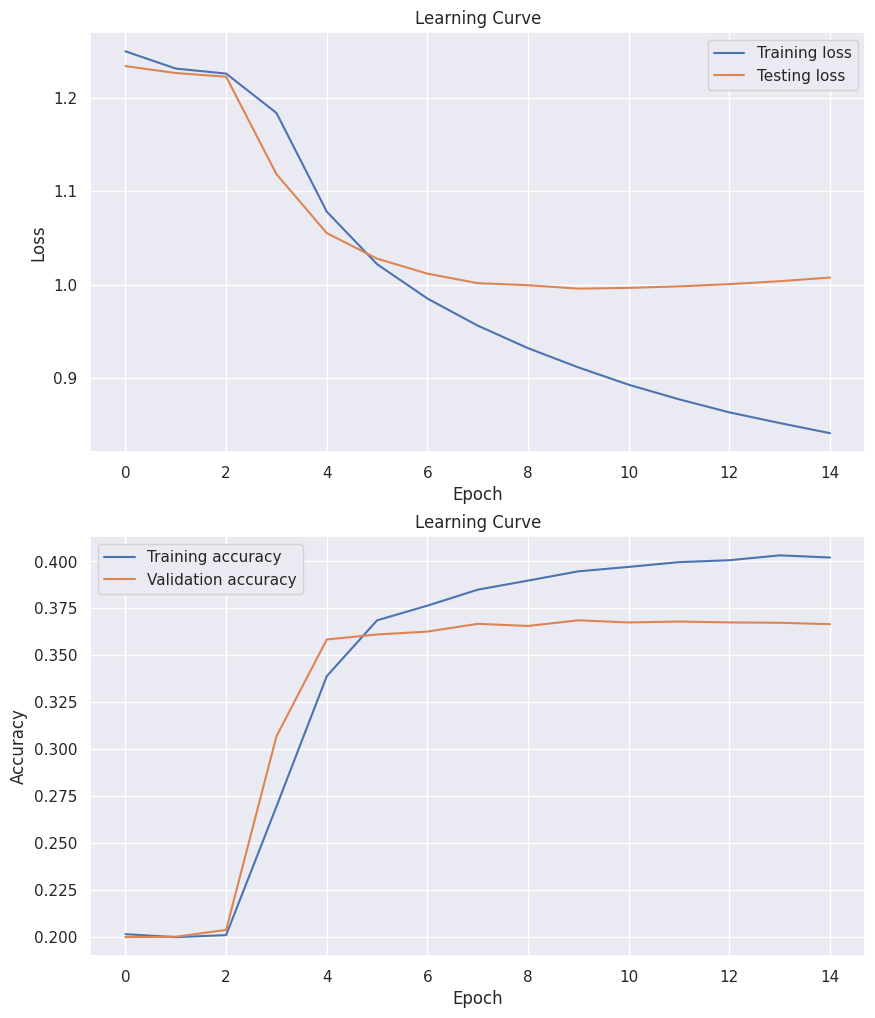

In [148]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_3 = flatten(embedding_dim, num_epochs, batch_size, 'softmax')

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 50, 32)            640000    
                                                                 
 flatten_14 (Flatten)        (None, 1600)              0         
                                                                 
 dense_82 (Dense)            (None, 16)                25616     
                                                                 
 dense_83 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 5s - loss: 1.1460 - accuracy: 0.2315 - val_loss: 1.0900 - val_accuracy: 0.3126 - 5s/epoch - 44ms/step
Epoch 2/15
120/120 - 4s - 

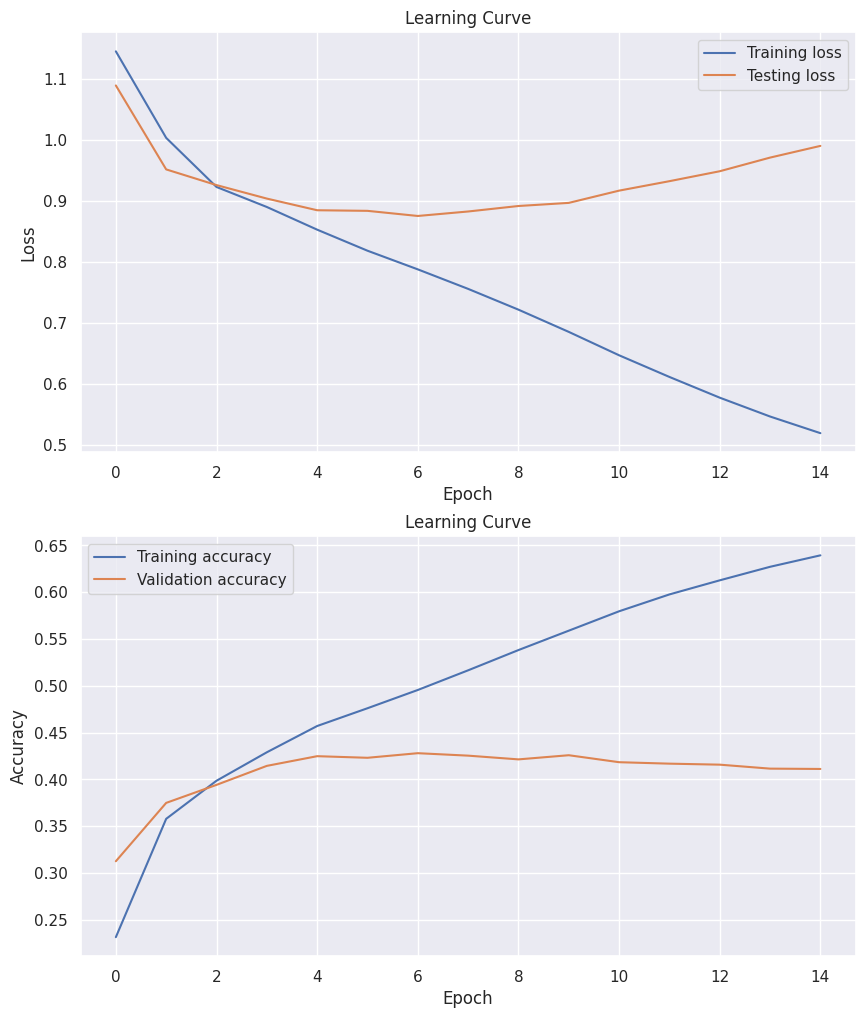

In [149]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_4 = flatten(embedding_dim, num_epochs, batch_size, 'tanh')

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 50, 32)            640000    
                                                                 
 flatten_15 (Flatten)        (None, 1600)              0         
                                                                 
 dense_84 (Dense)            (None, 16)                25616     
                                                                 
 dense_85 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 4s - loss: 1.1571 - accuracy: 0.2430 - val_loss: 1.0935 - val_accuracy: 0.3177 - 4s/epoch - 35ms/step
Epoch 2/15
120/120 - 3s - 

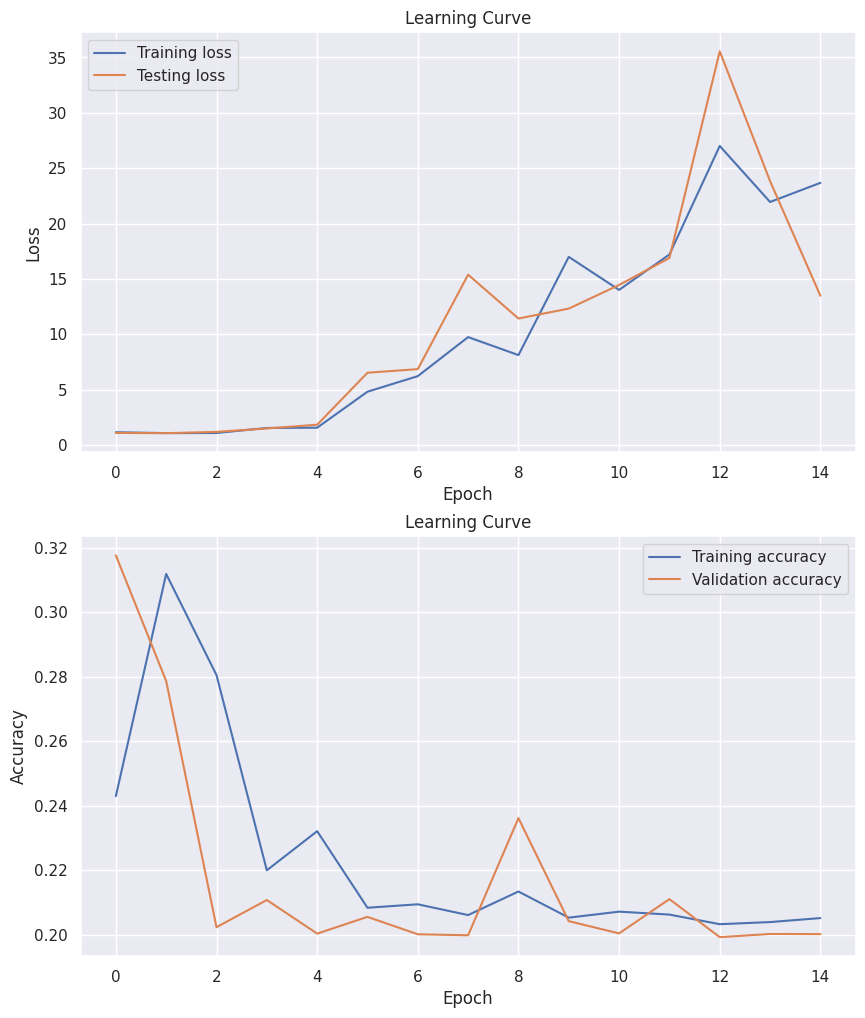

In [150]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_flatten_5 = flatten(embedding_dim, num_epochs, batch_size, 'leaky_relu')

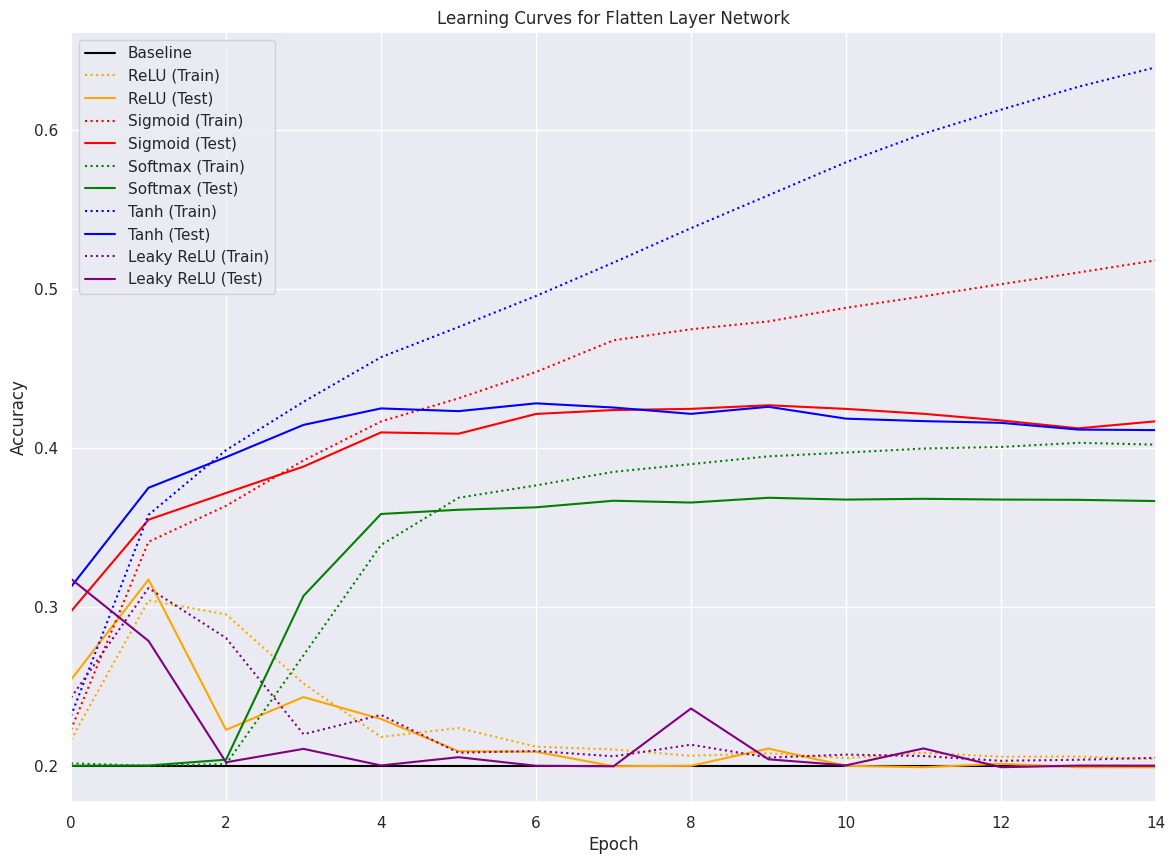

In [153]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))
sns.set()

plt.axhline(0.2, label='Baseline', color='black')
plt.plot(history_flatten_1.history['accuracy'], label='ReLU (Train)', color='orange', linestyle='dotted')
plt.plot(history_flatten_1.history['val_accuracy'], label='ReLU (Test)', color='orange')
plt.plot(history_flatten_2.history['accuracy'], label='Sigmoid (Train)', color='red', linestyle='dotted')
plt.plot(history_flatten_2.history['val_accuracy'], label='Sigmoid (Test)', color='red')
plt.plot(history_flatten_3.history['accuracy'], label='Softmax (Train)', color='green', linestyle='dotted')
plt.plot(history_flatten_3.history['val_accuracy'], label='Softmax (Test)', color='green')
plt.plot(history_flatten_4.history['accuracy'], label='Tanh (Train)', color='blue', linestyle='dotted')
plt.plot(history_flatten_4.history['val_accuracy'], label='Tanh (Test)', color='blue')
plt.plot(history_flatten_5.history['accuracy'], label='Leaky ReLU (Train)', color='purple', linestyle='dotted')
plt.plot(history_flatten_5.history['val_accuracy'], label='Leaky ReLU (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
# plt.ylim((0.2,0.8))
plt.title('Learning Curves for Flatten Layer Network')

plt.show()

### Experimenting with activation layers [convolution layer]
---

In [159]:
def convolution(embedding_dim, num_epochs, batch_size, activation_func):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation=activation_func),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  model.summary()

  history = model.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

  learning_curve(history)

  return history

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
 5 (GlobalAveragePooling1D)                                      
                                                                 
 dense_89 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 33s - loss: 1.1448 - accuracy: 0.2015 - val_loss: 1.1076 - val

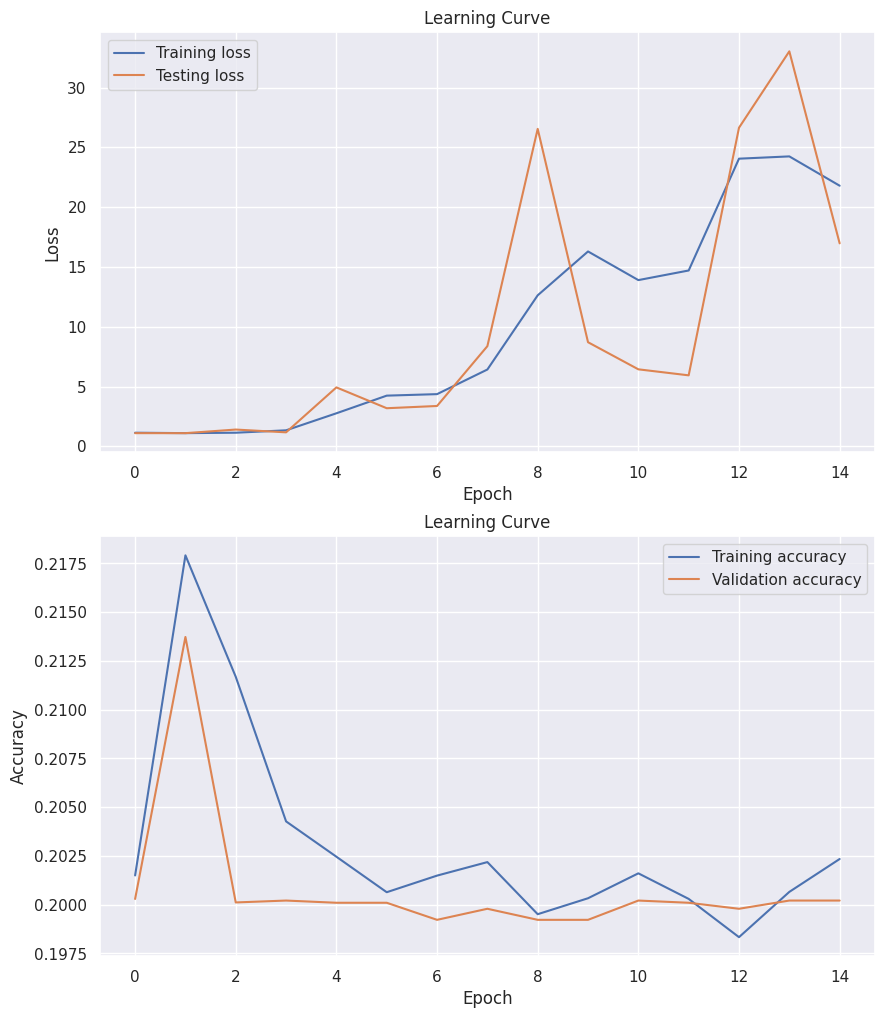

In [160]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_1 = convolution(embedding_dim, num_epochs, batch_size, 'relu')

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dense_90 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 26s - loss: 1.1670 - accuracy: 0.2053 - val_loss: 1.1577 - val

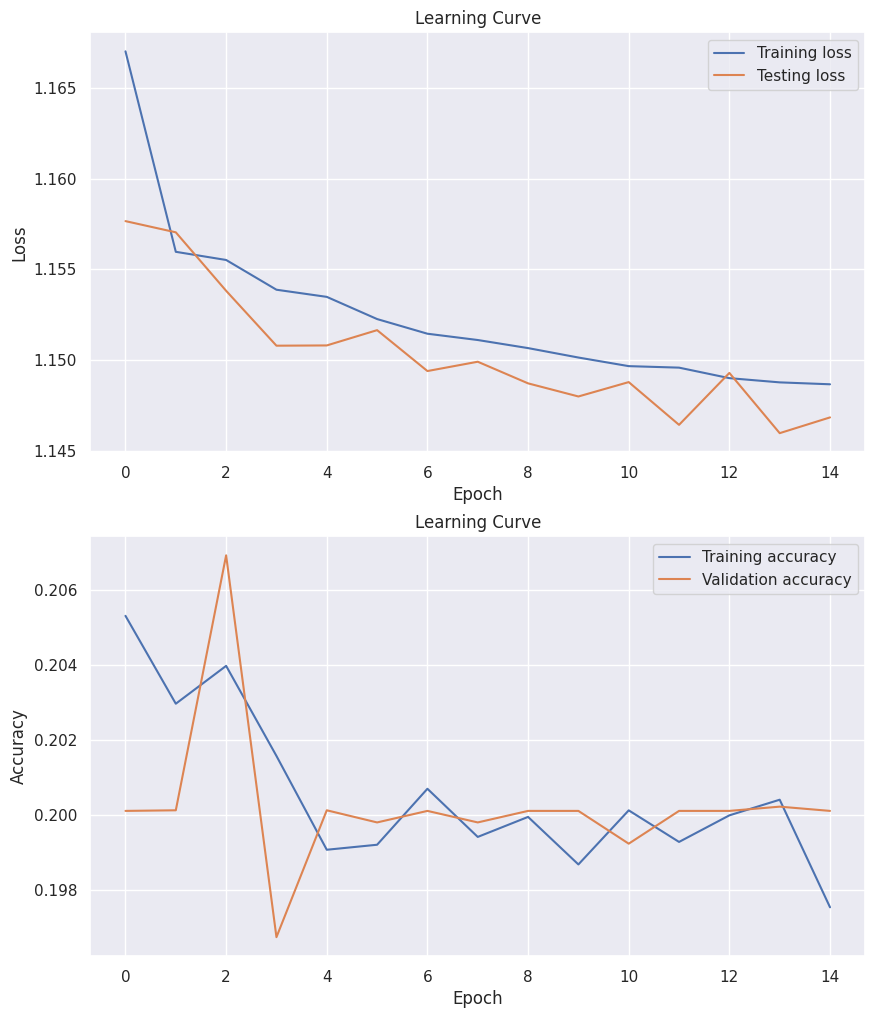

In [161]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_2 = convolution(embedding_dim, num_epochs, batch_size, 'sigmoid')

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_6 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
 7 (GlobalAveragePooling1D)                                      
                                                                 
 dense_91 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 28s - loss: 1.2665 - accuracy: 0.1997 - val_loss: 1.2457 - val

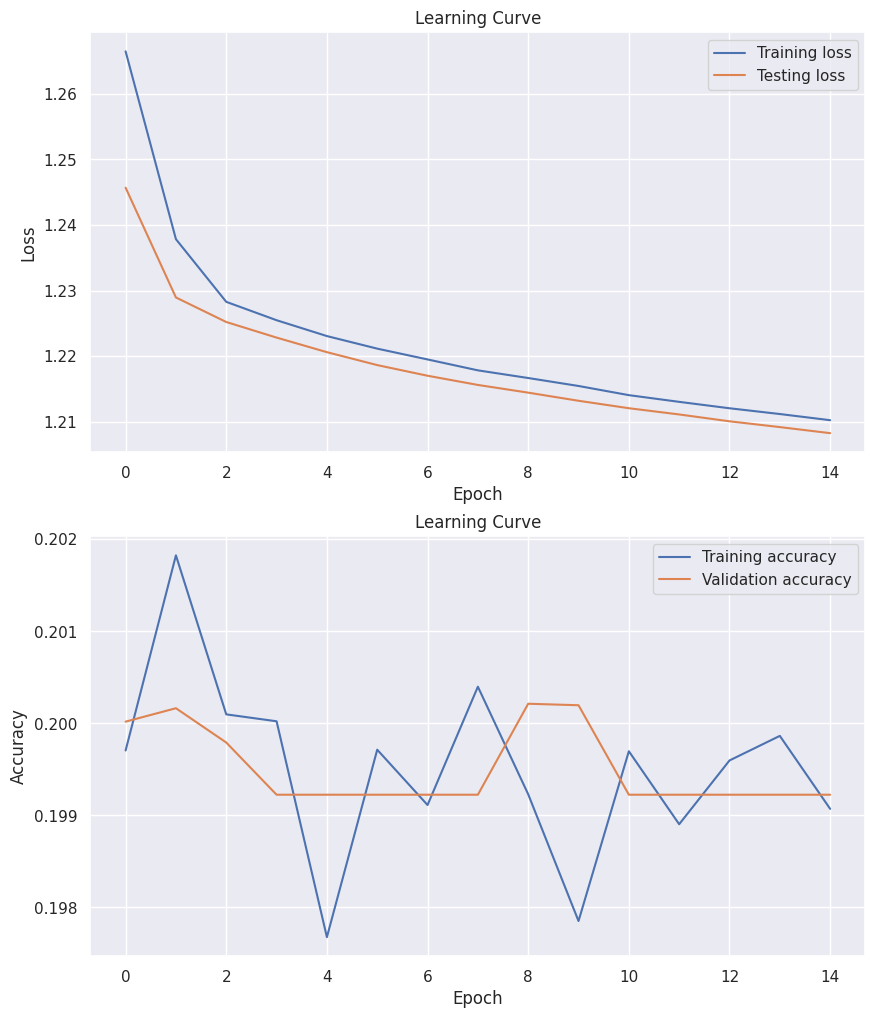

In [162]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_3 = convolution(embedding_dim, num_epochs, batch_size, 'softmax')

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_7 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
 8 (GlobalAveragePooling1D)                                      
                                                                 
 dense_92 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 23s - loss: 1.1353 - accuracy: 0.2215 - val_loss: 1.1117 - val

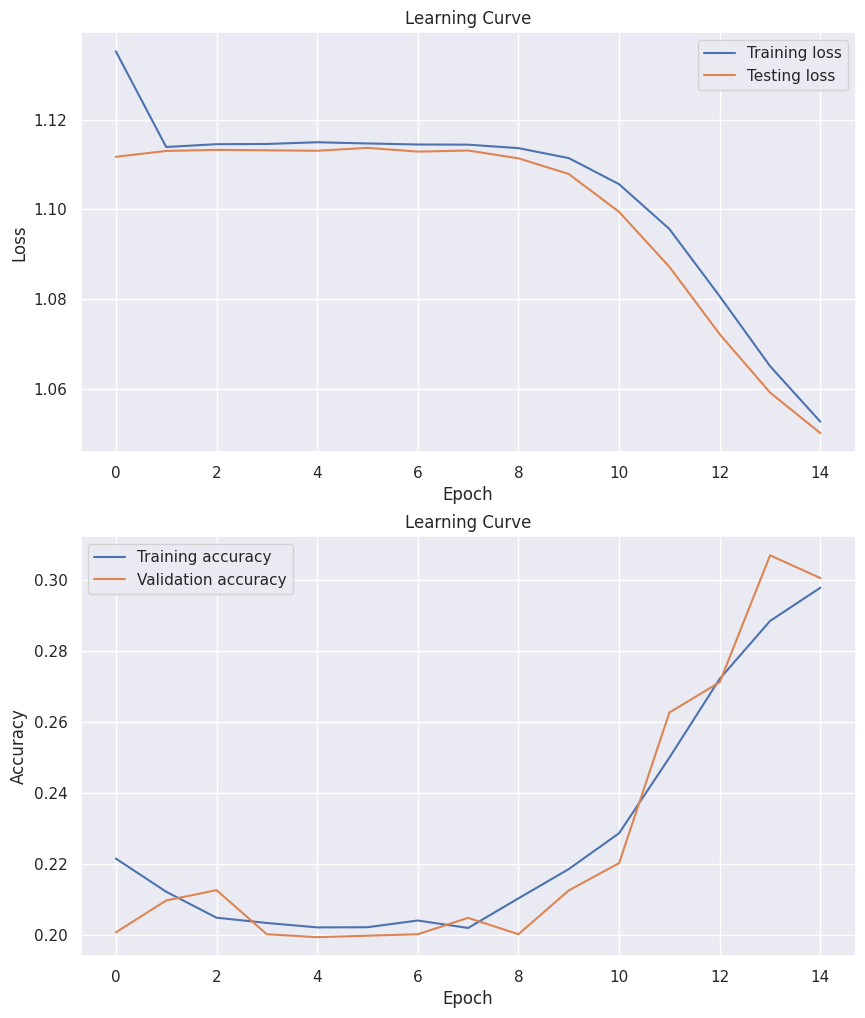

In [163]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_4 = convolution(embedding_dim, num_epochs, batch_size, 'tanh')

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 50, 32)            640000    
                                                                 
 conv1d_8 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
 9 (GlobalAveragePooling1D)                                      
                                                                 
 dense_93 (Dense)            (None, 5)                 645       
                                                                 
Total params: 661253 (2.52 MB)
Trainable params: 661253 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
120/120 - 23s - loss: 1.1445 - accuracy: 0.2104 - val_loss: 1.1097 - val

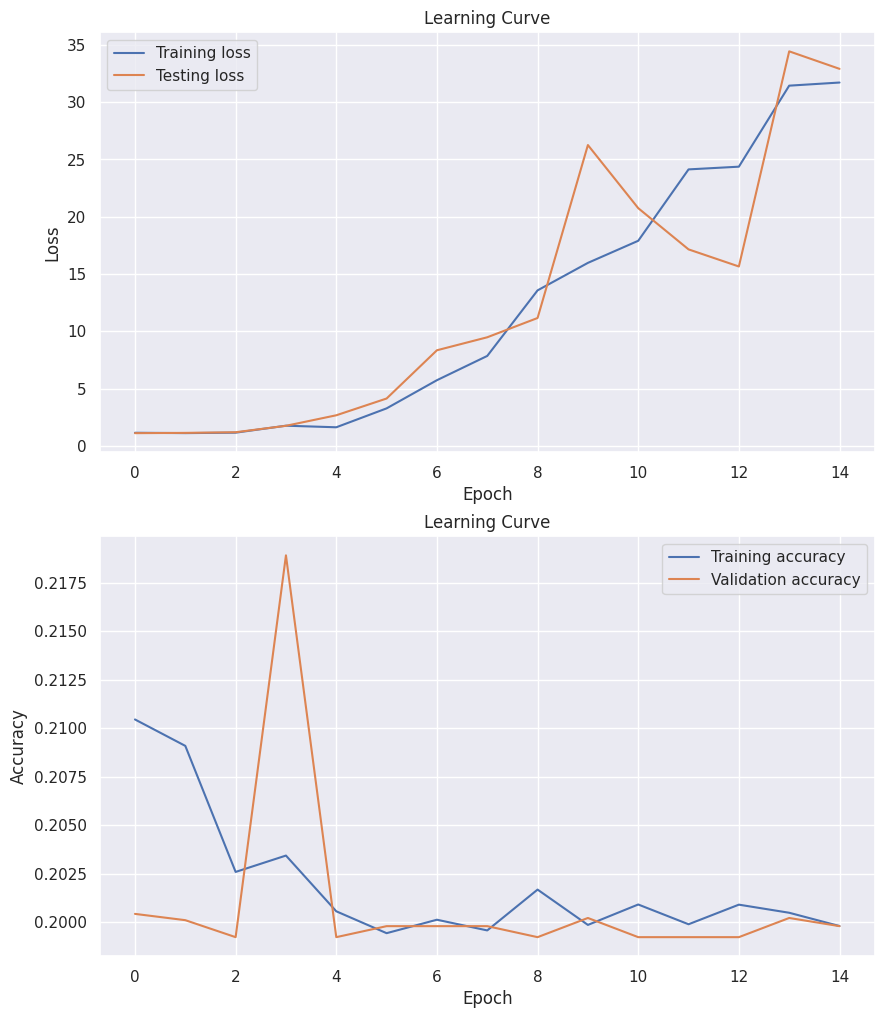

In [164]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

history_conv_5 = convolution(embedding_dim, num_epochs, batch_size, 'leaky_relu')

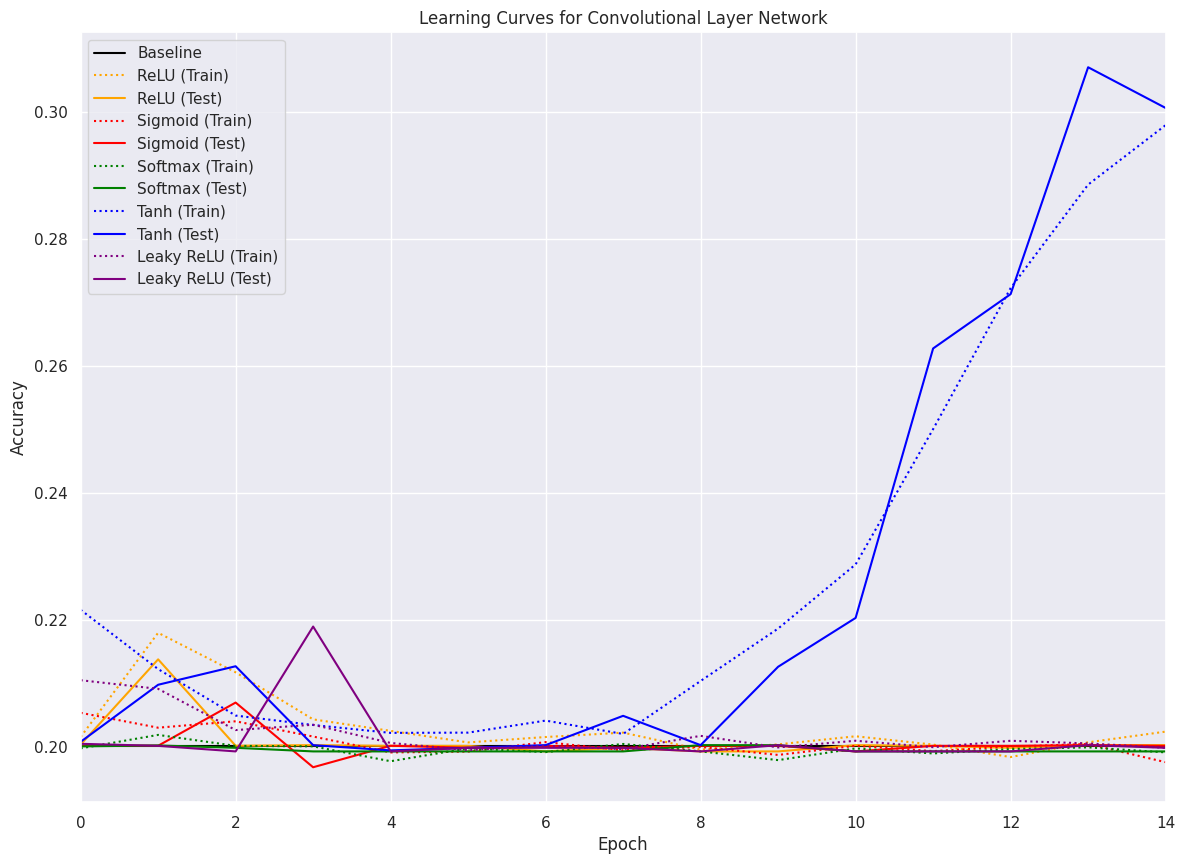

In [165]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))
sns.set()

plt.axhline(0.2, label='Baseline', color='black')
plt.plot(history_conv_1.history['accuracy'], label='ReLU (Train)', color='orange', linestyle='dotted')
plt.plot(history_conv_1.history['val_accuracy'], label='ReLU (Test)', color='orange')
plt.plot(history_conv_2.history['accuracy'], label='Sigmoid (Train)', color='red', linestyle='dotted')
plt.plot(history_conv_2.history['val_accuracy'], label='Sigmoid (Test)', color='red')
plt.plot(history_conv_3.history['accuracy'], label='Softmax (Train)', color='green', linestyle='dotted')
plt.plot(history_conv_3.history['val_accuracy'], label='Softmax (Test)', color='green')
plt.plot(history_conv_4.history['accuracy'], label='Tanh (Train)', color='blue', linestyle='dotted')
plt.plot(history_conv_4.history['val_accuracy'], label='Tanh (Test)', color='blue')
plt.plot(history_conv_5.history['accuracy'], label='Leaky ReLU (Train)', color='purple', linestyle='dotted')
plt.plot(history_conv_5.history['val_accuracy'], label='Leaky ReLU (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
# plt.ylim((0.2,0.8))
plt.title('Learning Curves for Convolutional Layer Network')

plt.show()

### Experimenting with model architectures
---

In [172]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# Average pooling
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
])
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [173]:
model1.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 50, 16)            320000    
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_94 (Dense)            (None, 5)                 85        
                                                                 
Total params: 320085 (1.22 MB)
Trainable params: 320085 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [174]:
history1 = model1.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 4s - loss: 1.2528 - accuracy: 0.2861 - val_loss: 1.2154 - val_accuracy: 0.3583 - 4s/epoch - 31ms/step
Epoch 2/15
120/120 - 2s - loss: 1.1869 - accuracy: 0.3702 - val_loss: 1.1598 - val_accuracy: 0.3754 - 2s/epoch - 14ms/step
Epoch 3/15
120/120 - 2s - loss: 1.1400 - accuracy: 0.3890 - val_loss: 1.1232 - val_accuracy: 0.3759 - 2s/epoch - 13ms/step
Epoch 4/15
120/120 - 2s - loss: 1.1095 - accuracy: 0.3913 - val_loss: 1.0992 - val_accuracy: 0.3827 - 2s/epoch - 14ms/step
Epoch 5/15
120/120 - 2s - loss: 1.0885 - accuracy: 0.3910 - val_loss: 1.0828 - val_accuracy: 0.3739 - 2s/epoch - 14ms/step
Epoch 6/15
120/120 - 2s - loss: 1.0737 - accuracy: 0.3902 - val_loss: 1.0705 - val_accuracy: 0.3828 - 2s/epoch - 14ms/step
Epoch 7/15
120/120 - 2s - loss: 1.0632 - accuracy: 0.3895 - val_loss: 1.0621 - val_accuracy: 0.3778 - 2s/epoch - 14ms/step
Epoch 8/15
120/120 - 3s - loss: 1.0560 - accuracy: 0.3895 - val_loss: 1.0579 - val_accuracy: 0.3659 - 3s/epoch - 23ms/step
Epoch 9/15
120/1

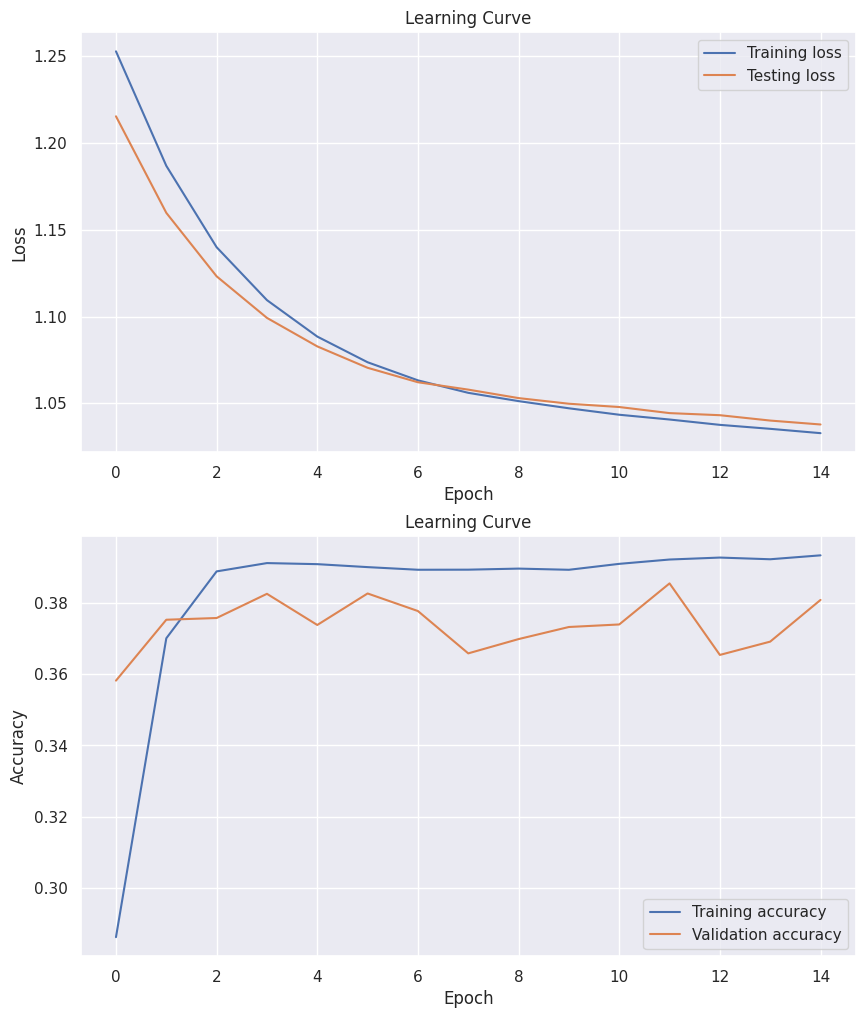

In [175]:
learning_curve(history1)

In [196]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# LSTM setup
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [197]:
history2 = model2.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 25s - loss: 1.1693 - accuracy: 0.2680 - val_loss: 1.0865 - val_accuracy: 0.3201 - 25s/epoch - 208ms/step
Epoch 2/15
120/120 - 16s - loss: 1.0046 - accuracy: 0.3547 - val_loss: 0.9603 - val_accuracy: 0.3645 - 16s/epoch - 130ms/step
Epoch 3/15
120/120 - 16s - loss: 0.9382 - accuracy: 0.3771 - val_loss: 0.9430 - val_accuracy: 0.3717 - 16s/epoch - 131ms/step
Epoch 4/15
120/120 - 16s - loss: 0.9194 - accuracy: 0.3860 - val_loss: 0.9443 - val_accuracy: 0.3718 - 16s/epoch - 129ms/step
Epoch 5/15
120/120 - 18s - loss: 0.9081 - accuracy: 0.3947 - val_loss: 0.9384 - val_accuracy: 0.3785 - 18s/epoch - 150ms/step
Epoch 6/15
120/120 - 15s - loss: 0.8990 - accuracy: 0.4017 - val_loss: 0.9385 - val_accuracy: 0.3816 - 15s/epoch - 126ms/step
Epoch 7/15
120/120 - 16s - loss: 0.8905 - accuracy: 0.4113 - val_loss: 0.9417 - val_accuracy: 0.3808 - 16s/epoch - 129ms/step
Epoch 8/15
120/120 - 15s - loss: 0.8800 - accuracy: 0.4207 - val_loss: 0.9412 - val_accuracy: 0.3824 - 15s/epoch - 129

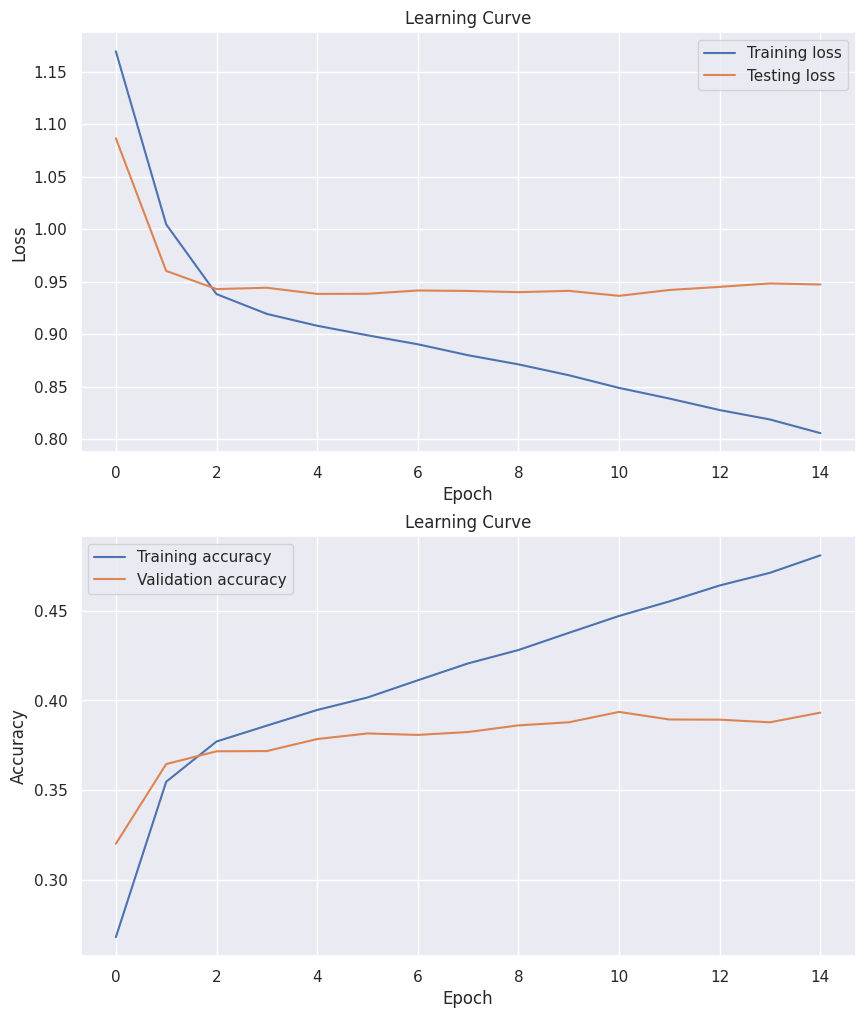

In [198]:
learning_curve(history2)

In [179]:
# model hyperparameters
embedding_dim = 32
num_epochs = 15
batch_size = 1000

# flatten layer
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [180]:
model3.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, 50, 32)            640000    
                                                                 
 flatten_16 (Flatten)        (None, 1600)              0         
                                                                 
 dense_97 (Dense)            (None, 16)                25616     
                                                                 
 dense_98 (Dense)            (None, 5)                 85        
                                                                 
Total params: 665701 (2.54 MB)
Trainable params: 665701 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
history3 = model3.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 4s - loss: 1.2959 - accuracy: 0.2013 - val_loss: 1.2100 - val_accuracy: 0.2004 - 4s/epoch - 36ms/step
Epoch 2/15
120/120 - 4s - loss: 1.1990 - accuracy: 0.2296 - val_loss: 1.1836 - val_accuracy: 0.2598 - 4s/epoch - 36ms/step
Epoch 3/15
120/120 - 3s - loss: 1.1447 - accuracy: 0.2971 - val_loss: 1.0873 - val_accuracy: 0.3416 - 3s/epoch - 26ms/step
Epoch 4/15
120/120 - 3s - loss: 1.0378 - accuracy: 0.3634 - val_loss: 1.0219 - val_accuracy: 0.3842 - 3s/epoch - 29ms/step
Epoch 5/15
120/120 - 4s - loss: 0.9906 - accuracy: 0.4077 - val_loss: 0.9868 - val_accuracy: 0.4035 - 4s/epoch - 30ms/step
Epoch 6/15
120/120 - 4s - loss: 0.9492 - accuracy: 0.4356 - val_loss: 0.9644 - val_accuracy: 0.4164 - 4s/epoch - 35ms/step
Epoch 7/15
120/120 - 3s - loss: 0.9188 - accuracy: 0.4581 - val_loss: 0.9467 - val_accuracy: 0.4241 - 3s/epoch - 26ms/step
Epoch 8/15
120/120 - 3s - loss: 0.8923 - accuracy: 0.4752 - val_loss: 0.9369 - val_accuracy: 0.4267 - 3s/epoch - 26ms/step
Epoch 9/15
120/1

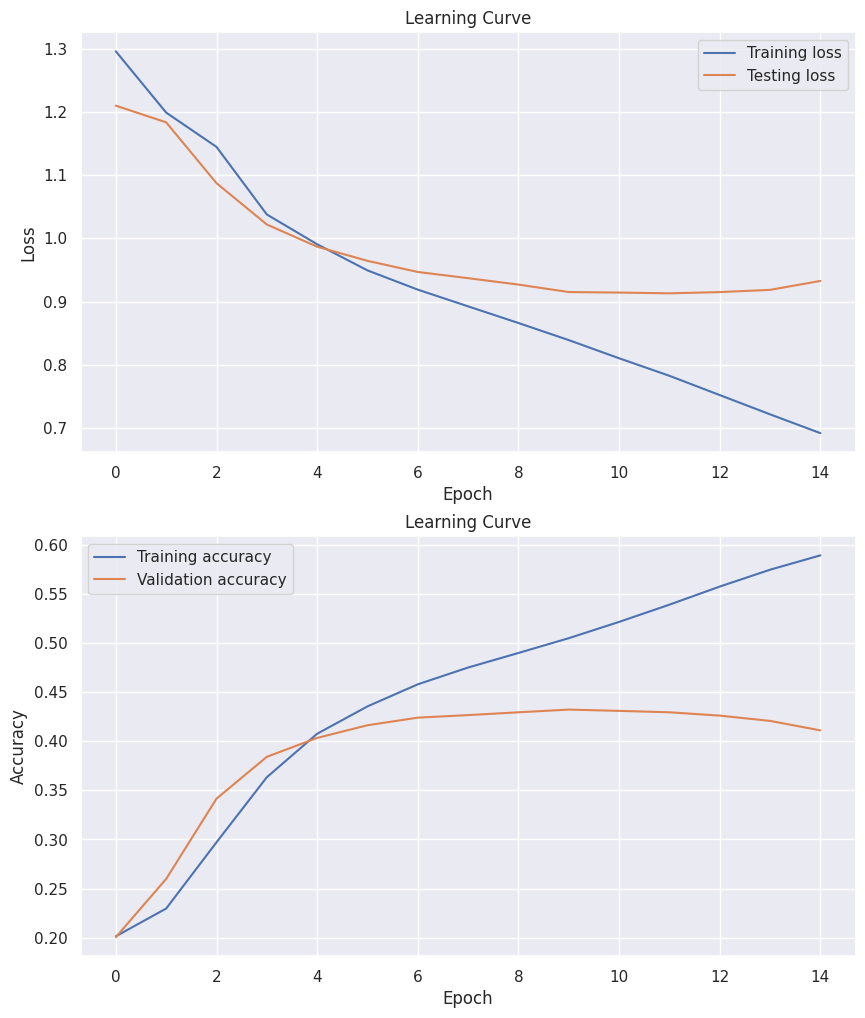

In [182]:
learning_curve(history3)

In [183]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# convolution
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='tanh'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(5, activation='softmax')
])
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [184]:
model4.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 50, 16)            320000    
                                                                 
 conv1d_9 (Conv1D)           (None, 46, 128)           10368     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_99 (Dense)            (None, 5)                 645       
                                                                 
Total params: 331013 (1.26 MB)
Trainable params: 331013 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [185]:
history4 = model4.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 35s - loss: 1.1327 - accuracy: 0.2788 - val_loss: 1.0578 - val_accuracy: 0.3271 - 35s/epoch - 288ms/step
Epoch 2/15
120/120 - 16s - loss: 1.0587 - accuracy: 0.3277 - val_loss: 1.0604 - val_accuracy: 0.3131 - 16s/epoch - 136ms/step
Epoch 3/15
120/120 - 15s - loss: 1.0415 - accuracy: 0.3222 - val_loss: 1.0335 - val_accuracy: 0.3155 - 15s/epoch - 127ms/step
Epoch 4/15
120/120 - 16s - loss: 1.0156 - accuracy: 0.3296 - val_loss: 1.0142 - val_accuracy: 0.3282 - 16s/epoch - 136ms/step
Epoch 5/15
120/120 - 16s - loss: 0.9974 - accuracy: 0.3399 - val_loss: 1.0004 - val_accuracy: 0.3376 - 16s/epoch - 137ms/step
Epoch 6/15
120/120 - 15s - loss: 0.9812 - accuracy: 0.3499 - val_loss: 0.9874 - val_accuracy: 0.3268 - 15s/epoch - 127ms/step
Epoch 7/15
120/120 - 16s - loss: 0.9675 - accuracy: 0.3517 - val_loss: 0.9795 - val_accuracy: 0.3402 - 16s/epoch - 136ms/step
Epoch 8/15
120/120 - 16s - loss: 0.9579 - accuracy: 0.3562 - val_loss: 0.9743 - val_accuracy: 0.3371 - 16s/epoch - 137

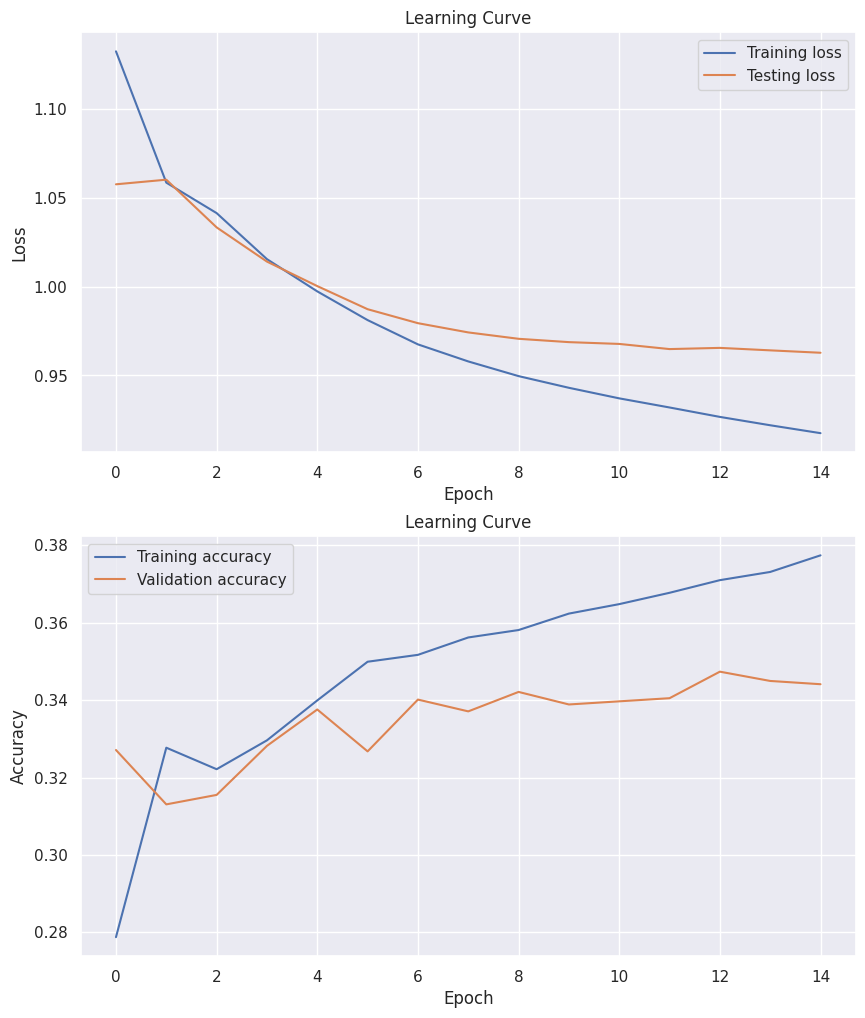

In [186]:
learning_curve(history4)

In [187]:
# model hyperparameters
embedding_dim = 16
num_epochs = 15
batch_size = 1000

# more complicated LSTM setup
model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [188]:
model5.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 50, 16)            320000    
                                                                 
 bidirectional_8 (Bidirecti  (None, 50, 64)            12544     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_100 (Dense)           (None, 8)                 264       
                                                                 
 dense_101 (Dense)           (None, 5)                 45        
                                                                 
Total params: 343221 (1.31 MB)
Trainable params: 3432

In [189]:
history5 = model5.fit(train_padded, tf.one_hot(train_labels_int,5), batch_size=batch_size, epochs=num_epochs, validation_data=(test_padded, tf.one_hot(test_labels_int,5)), verbose=2)

Epoch 1/15
120/120 - 96s - loss: 1.1188 - accuracy: 0.2751 - val_loss: 0.9331 - val_accuracy: 0.3792 - 96s/epoch - 800ms/step
Epoch 2/15
120/120 - 86s - loss: 0.8826 - accuracy: 0.4164 - val_loss: 0.8833 - val_accuracy: 0.4186 - 86s/epoch - 719ms/step
Epoch 3/15
120/120 - 87s - loss: 0.8453 - accuracy: 0.4470 - val_loss: 0.8839 - val_accuracy: 0.4252 - 87s/epoch - 724ms/step
Epoch 4/15
120/120 - 84s - loss: 0.8316 - accuracy: 0.4585 - val_loss: 0.8856 - val_accuracy: 0.4191 - 84s/epoch - 698ms/step
Epoch 5/15
120/120 - 86s - loss: 0.8185 - accuracy: 0.4596 - val_loss: 0.8902 - val_accuracy: 0.4116 - 86s/epoch - 713ms/step
Epoch 6/15
120/120 - 86s - loss: 0.8171 - accuracy: 0.4560 - val_loss: 0.9144 - val_accuracy: 0.3932 - 86s/epoch - 720ms/step
Epoch 7/15
120/120 - 77s - loss: 0.8120 - accuracy: 0.4585 - val_loss: 0.9101 - val_accuracy: 0.3981 - 77s/epoch - 645ms/step
Epoch 8/15
120/120 - 84s - loss: 0.7997 - accuracy: 0.4684 - val_loss: 0.9408 - val_accuracy: 0.3738 - 84s/epoch - 700

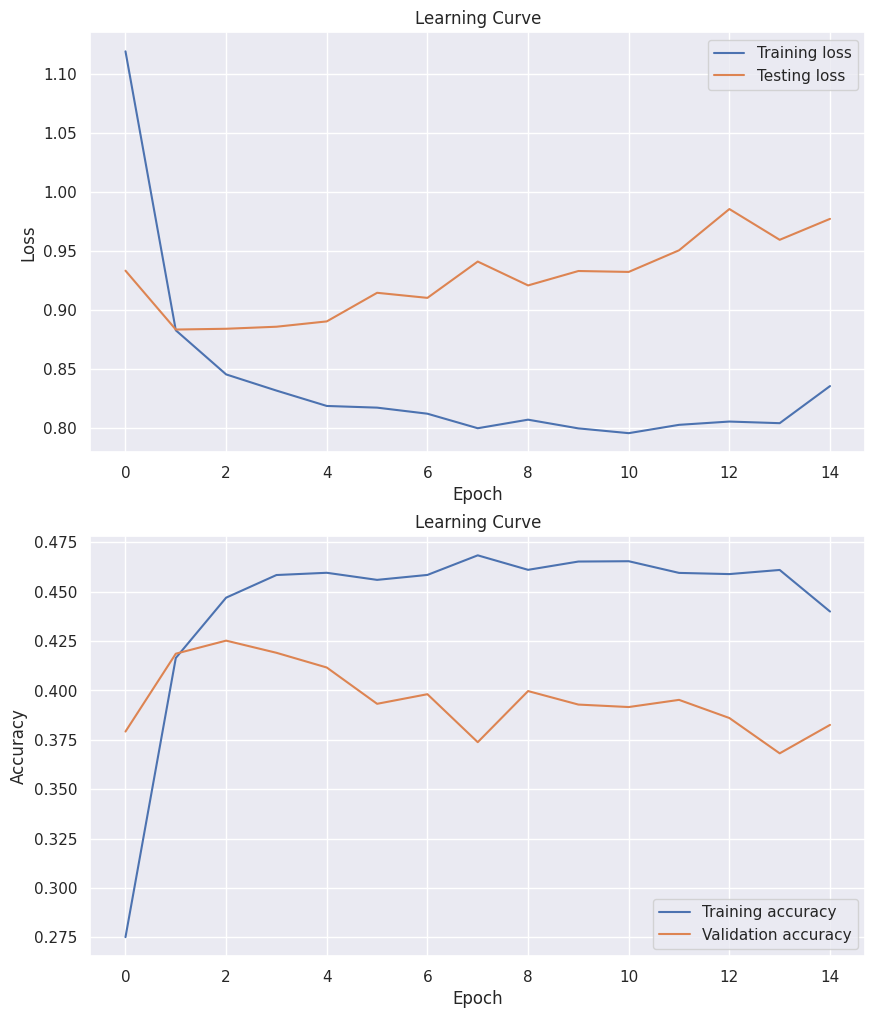

In [190]:
learning_curve(history5)

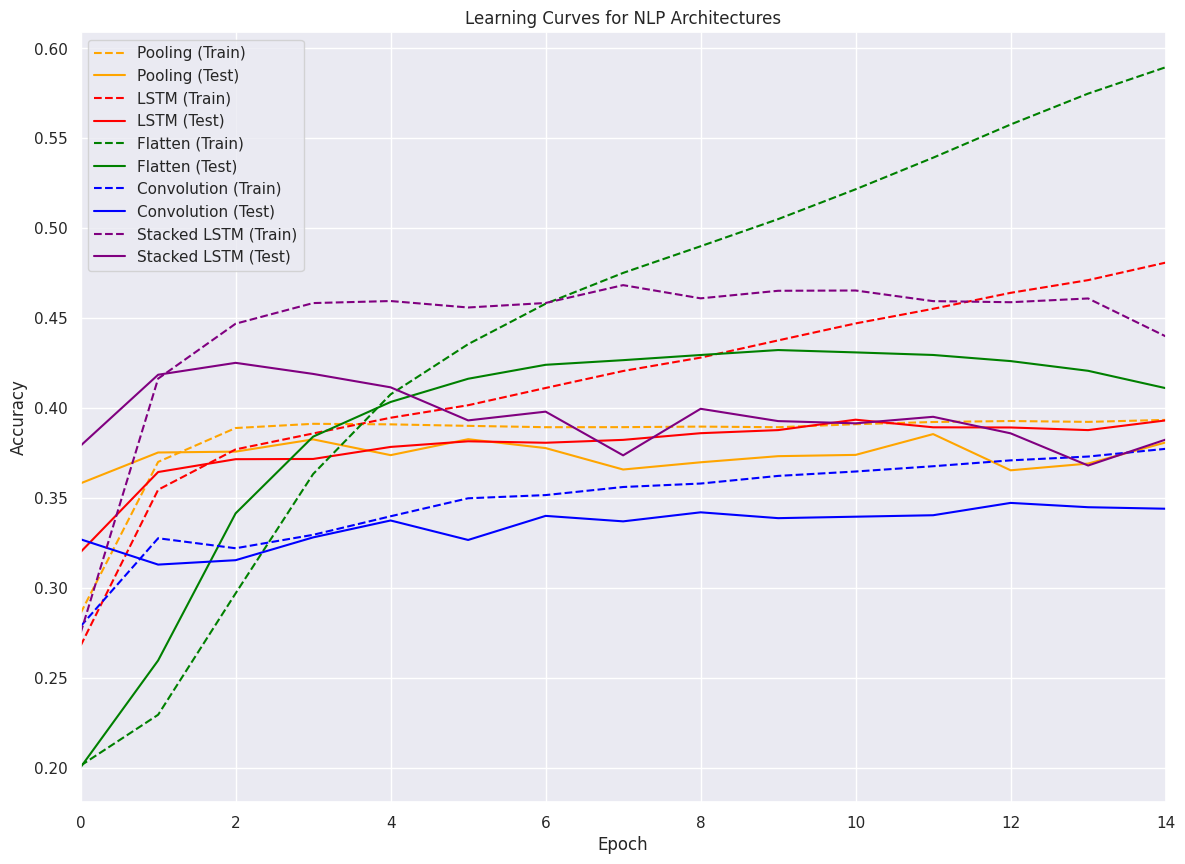

In [199]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))

# plt.axhline(0.33, label='Baseline', color='black')
plt.plot(history1.history['accuracy'], label='Pooling (Train)', color='orange', linestyle='dashed')
plt.plot(history1.history['val_accuracy'], label='Pooling (Test)', color='orange')
plt.plot(history2.history['accuracy'], label='LSTM (Train)', color='red', linestyle='dashed')
plt.plot(history2.history['val_accuracy'], label='LSTM (Test)', color='red')
plt.plot(history3.history['accuracy'], label='Flatten (Train)', color='green', linestyle='dashed')
plt.plot(history3.history['val_accuracy'], label='Flatten (Test)', color='green')
plt.plot(history4.history['accuracy'], label='Convolution (Train)', color='blue', linestyle='dashed')
plt.plot(history4.history['val_accuracy'], label='Convolution (Test)', color='blue')
plt.plot(history5.history['accuracy'], label='Stacked LSTM (Train)', color='purple', linestyle='dashed')
plt.plot(history5.history['val_accuracy'], label='Stacked LSTM (Test)', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0,14)
#plt.ylim((0.5,0.8))
plt.title('Learning Curves for NLP Architectures')

plt.show()


In [ ]:
# # serialize model to JSON
# model_json = model5.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model5.save_weights("model.h5")
# print("Saved model to disk")

In [ ]:
# # code for loading json and creating model from the previously saved model data
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

# Model Applicaton

# Model Extensions